# Modelo de Regresión para predecir la Edad de Cangrejos, Datos de Kaggle.

In [2]:
# Librerias
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
import optuna

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.width", 100)
pd.set_option("display.precision", 3)
pd.options.display.float_format = '{:.3f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:95% }</style>"))

In [2]:
name = r"train.csv"
df_p = pd.read_csv(name)

In [3]:
df = df_p.copy()
df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.525,1.175,0.375,28.973,12.729,6.648,8.349,9
1,1,I,1.100,0.825,0.275,10.418,4.522,2.325,3.402,8
2,2,M,1.387,1.113,0.375,24.777,11.340,5.557,6.662,9
3,3,F,1.700,1.413,0.500,50.661,20.355,10.992,14.997,11
4,4,I,1.250,1.012,0.338,23.289,11.978,4.508,5.953,8


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


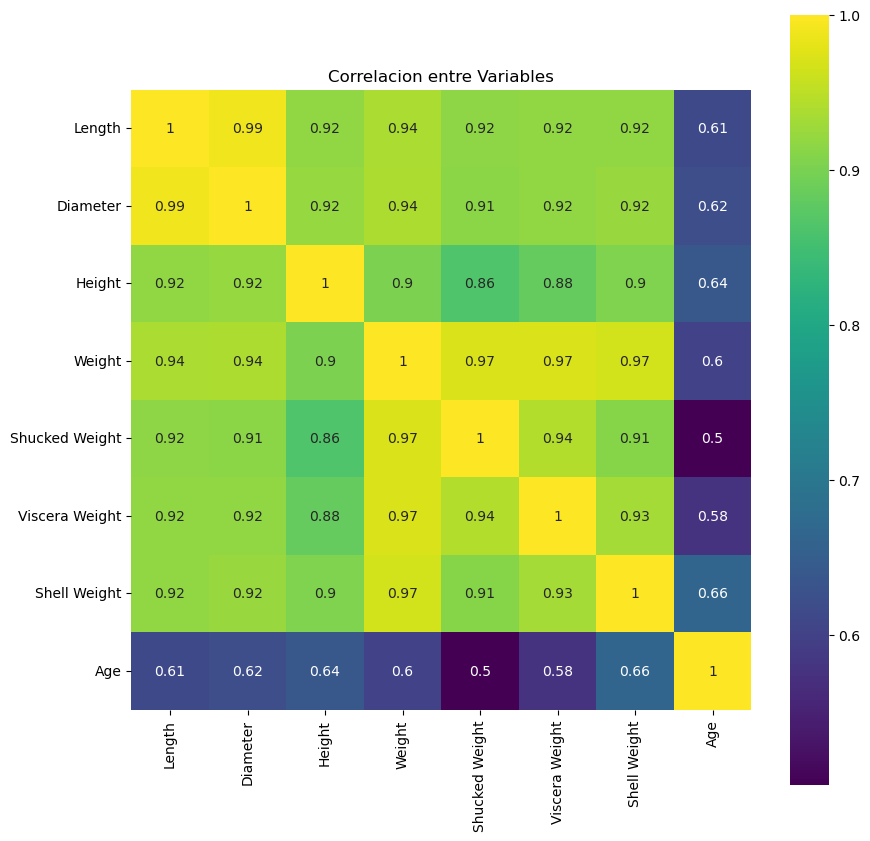

In [43]:
correlacion = df.iloc[:, 1:].corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(correlacion,vmax=1, square=True, annot=True, cmap="viridis")
plt.title("Correlacion entre Variables")
plt.show()

Se puede observar que existe relación entre las variables independientes, por lo que se usará PCA para reducir la dimensionalidad y elegir las mejores caracteristicas, por lo que resolveremos el problema de multicolinealidad.

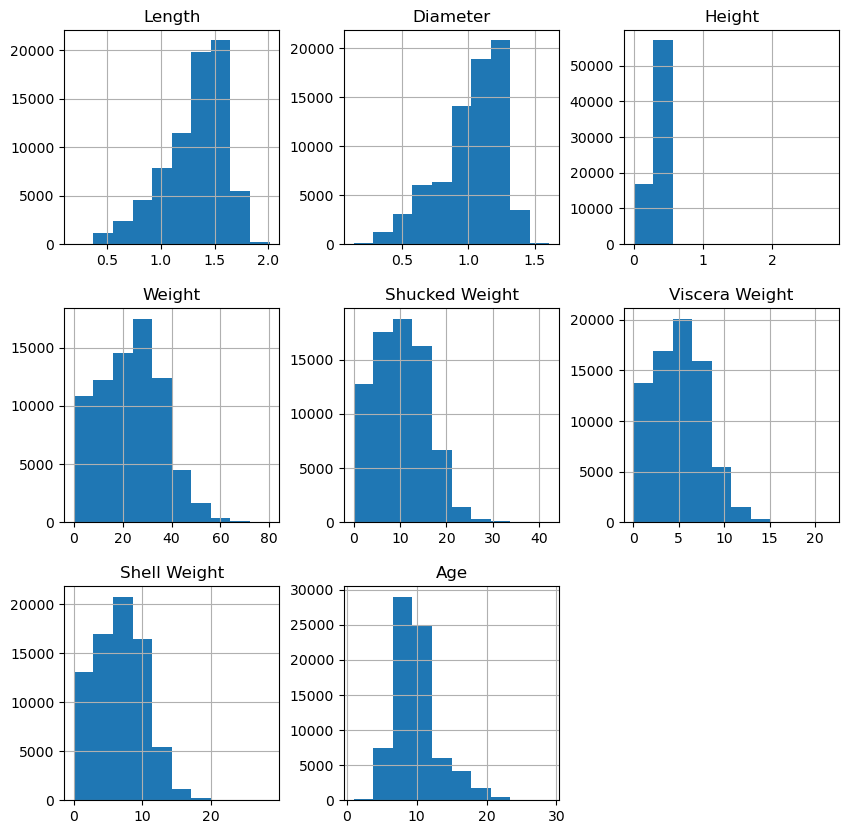

In [45]:
%matplotlib inline
# Univariate Histograms
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
df.iloc[:, 1:].hist(ax = ax)
plt.show()

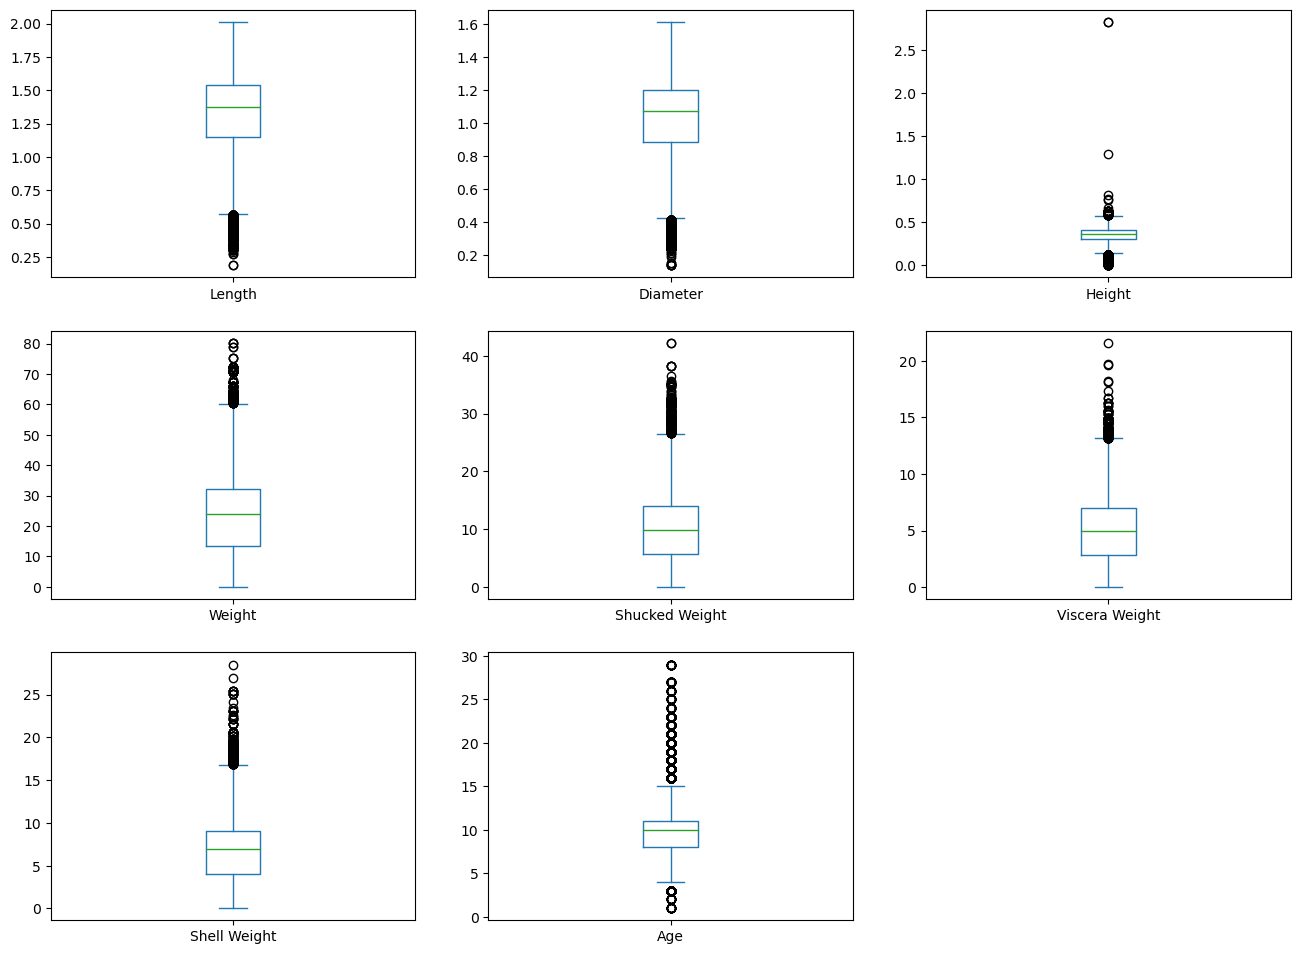

In [46]:
fig = plt.figure(figsize=(16,16))
ax = fig.gca()
df.iloc[:, 1:].plot(ax = ax, kind = "box", subplots=True, layout= (4,3), sharex=False)
plt.show()

Vemos que hay valores atipicos en nuestra variable dependiente, por lo que eliminaremos estos valores.

In [47]:
df.groupby("Sex").size()

Sex
F    23010
I    23957
M    27084
dtype: int64

In [22]:
anomalies = []
def find_anomalies(data):
    #identificar los limites mayores y menos, en dos veces la desviacion estandar.
    data_std = data.std()
    data_mean = data.mean()
    anomalia_cortada = data_std*2
    lower_limit = data_mean - anomalia_cortada
    upper_limit = data_mean + anomalia_cortada
    print("Limite superior:",lower_limit.iloc[0])
    print("Limite inferior:",upper_limit.iloc[0])
    
    #generar los outlyers
    for index, row in data.iterrows(): #data.iterrow, es por cada iteracion de la fila, en la data guardamos dos cosas, el index y la columna poblacion
        outlier = row # obtener la primera columna
        if (outlier.iloc[0] > upper_limit[0]) or (outlier.iloc[0] < lower_limit[0]):
            anomalies.append(index)
    #return anomalies
find_anomalies(df.set_index("id")[["Age"]])

Limite superior: 3.6174275699244127
Limite inferior: 16.31818437319587


In [23]:
for i in anomalies:
    df.drop(df[(df["id"]==i)].index, inplace=True)

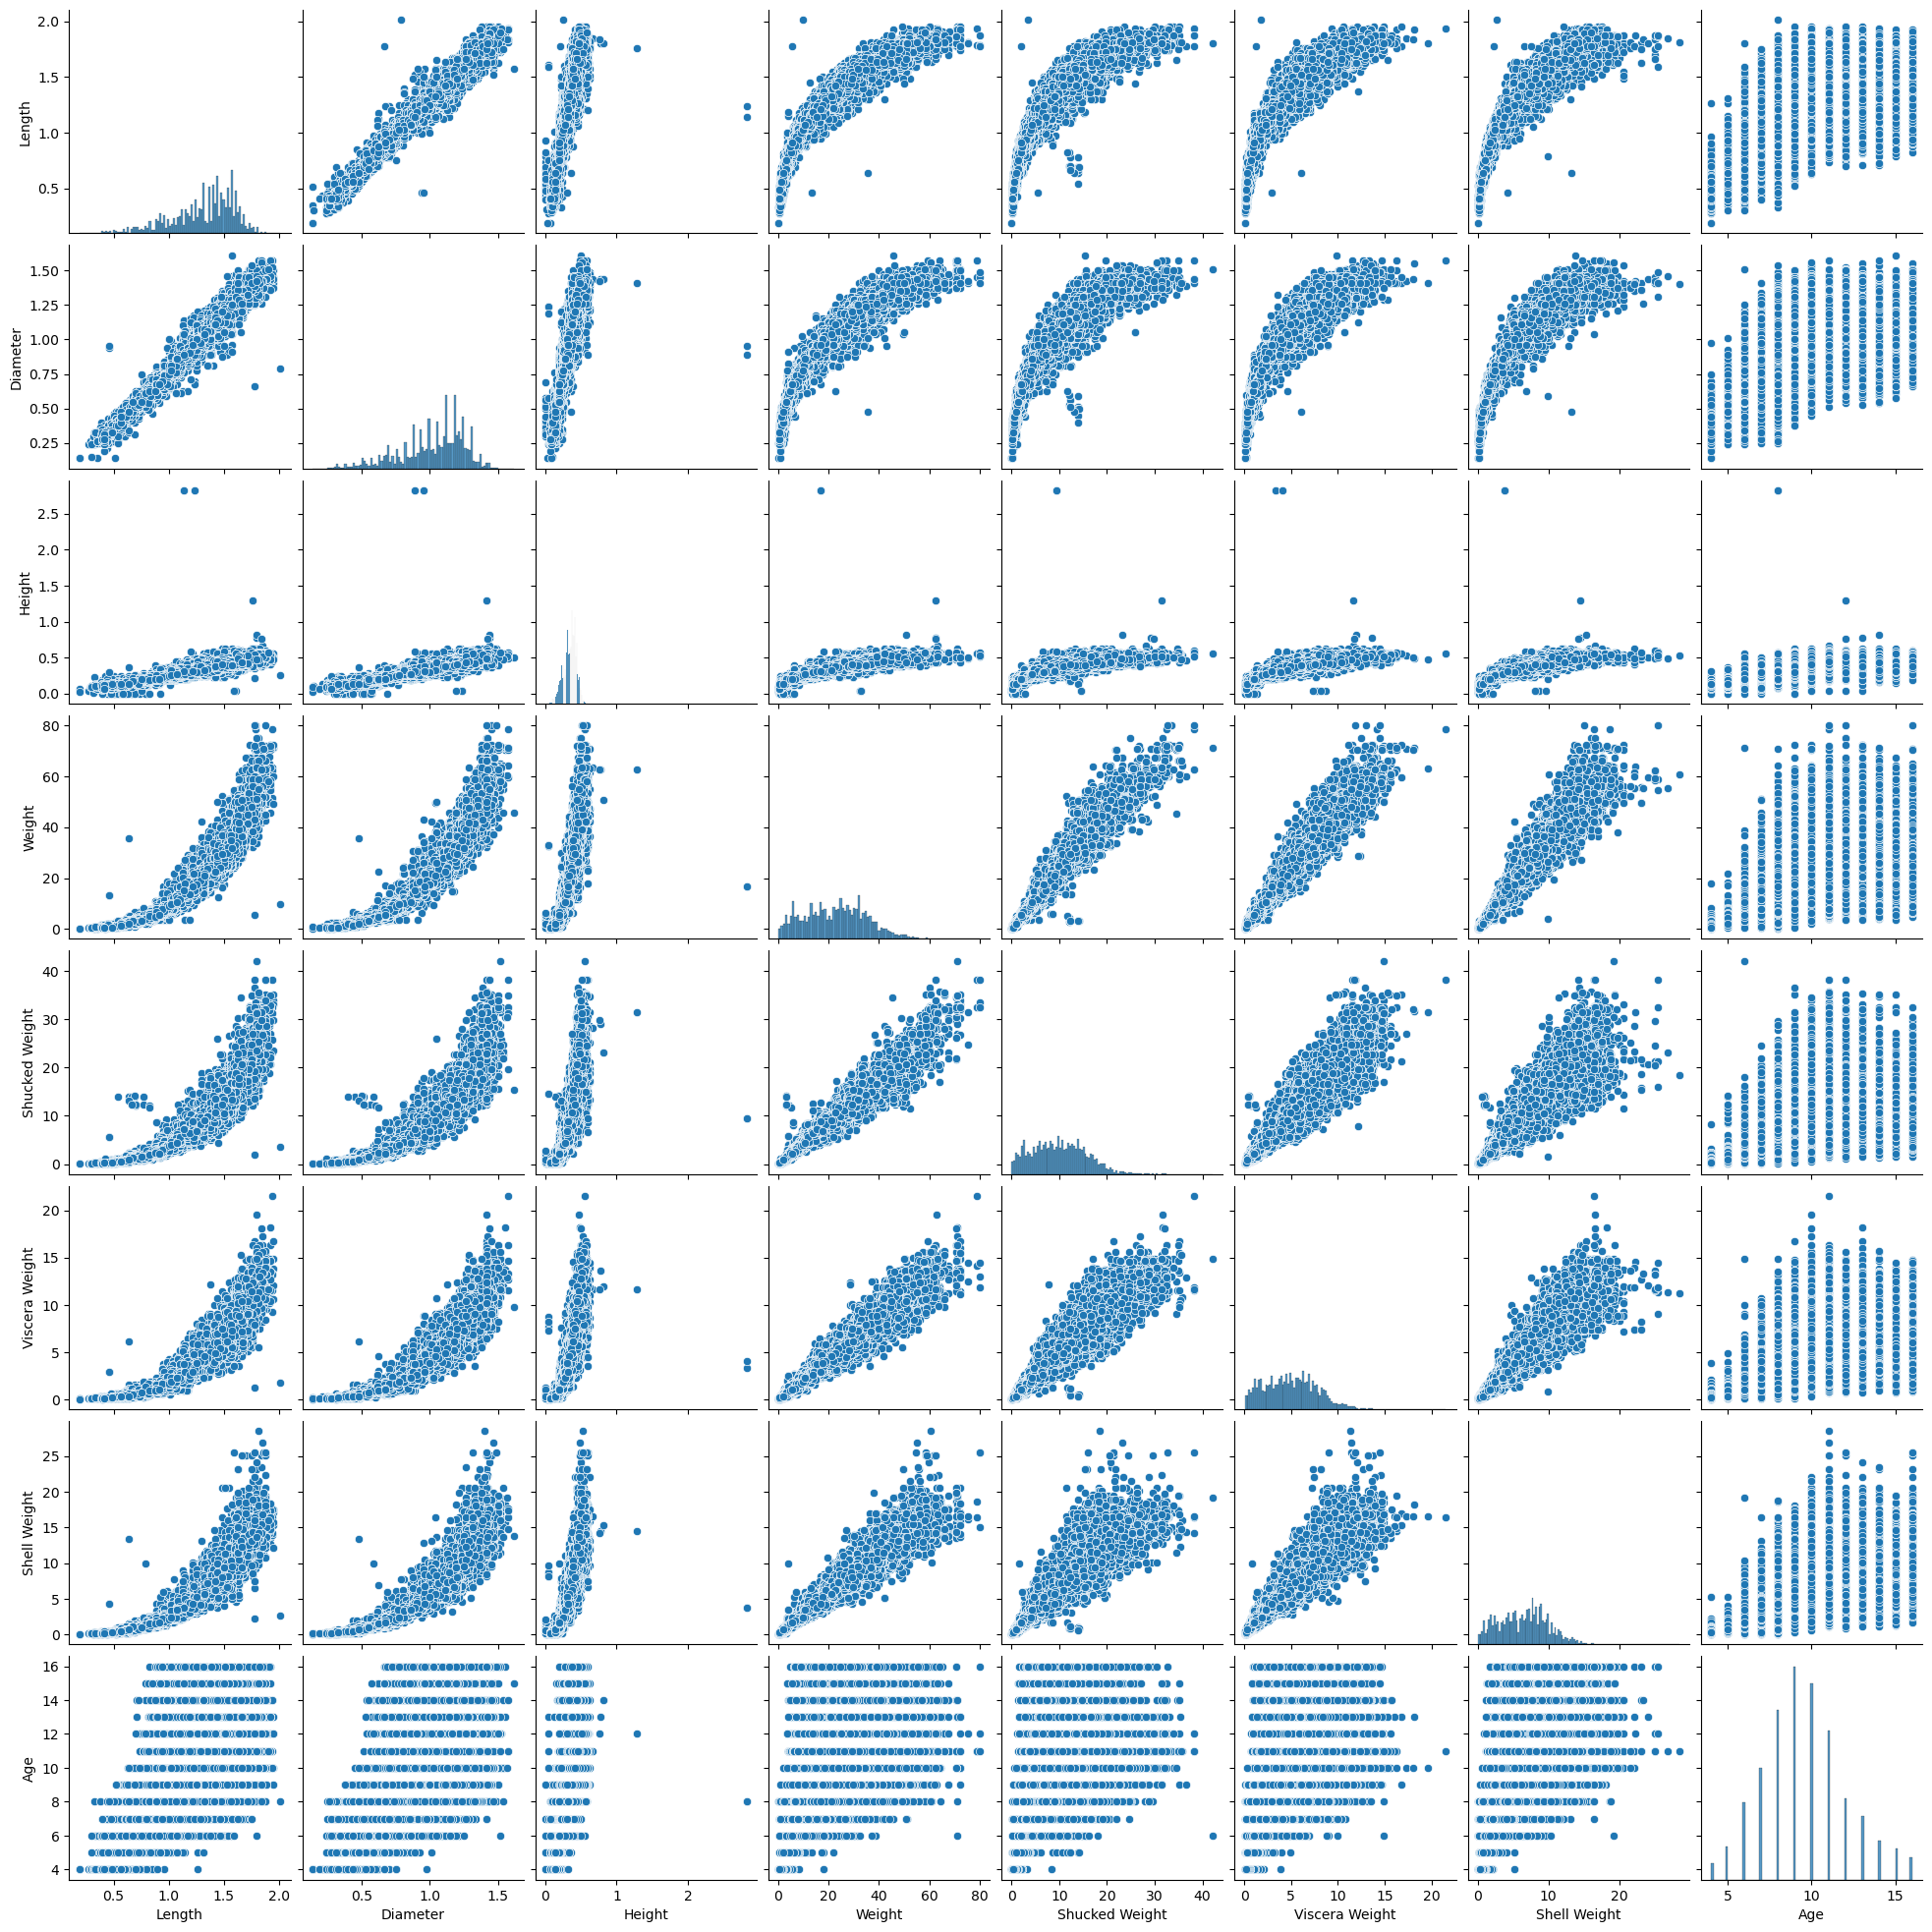

In [50]:
sns.pairplot(df.iloc[:, 1:])
plt.show()

In [24]:
del df["id"]

In [25]:
X = df.iloc[: , 0 :8]
y = df.iloc[: , 8:9]

In [26]:
X.to_csv("cangejo_X.csv", index=False)
y.to_csv("cangejo_Y.csv", index=False)

In [3]:
X = pd.read_csv(r"cangejo_X.csv")
y = pd.read_csv(r"cangejo_Y.csv")

In [4]:
X.head(3)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,I,1.525,1.175,0.375,28.973,12.729,6.648,8.349
1,I,1.100,0.825,0.275,10.418,4.522,2.325,3.402
2,M,1.387,1.113,0.375,24.777,11.340,5.557,6.662


In [5]:
X = pd.get_dummies(X, columns=['Sex'], prefix=['Sex'])
X.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.525,1.175,0.375,28.973,12.729,6.648,8.349,0,1,0
1,1.100,0.825,0.275,10.418,4.522,2.325,3.402,0,1,0
2,1.387,1.113,0.375,24.777,11.340,5.557,6.662,0,0,1
3,1.700,1.413,0.500,50.661,20.355,10.992,14.997,1,0,0
4,1.250,1.012,0.338,23.289,11.978,4.508,5.953,0,1,0


In [6]:
pt = PowerTransformer()
Ajuste = pt.fit(X)
X_train = Ajuste.transform(X)

In [7]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_train.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,0.752,0.635,0.330,0.540,0.555,0.655,0.563,-0.660,1.413,-0.755
1,-0.870,-0.937,-0.771,-0.981,-0.953,-0.938,-0.877,-0.660,1.413,-0.755
2,0.145,0.300,0.330,0.231,0.332,0.297,0.108,-0.660,-0.708,1.325
3,1.651,2.156,1.710,1.958,1.654,1.915,2.149,1.515,-0.708,-0.755
4,-0.380,-0.184,-0.083,0.118,0.436,-0.070,-0.092,-0.660,1.413,-0.755


In [8]:
cat_x = X_train.iloc[:,-3:]
del X_train["Sex_F"]
del X_train["Sex_I"]
del X_train["Sex_M"]

In [9]:
pca = PCA(n_components=2, random_state=7)
ajusteX = pca.fit(X_train)
X_pca = ajusteX.transform(X_train)
print((pca.explained_variance_ratio_))

df_pca = pd.DataFrame(data=X_pca, columns=["PC-1", "PC-2",])
df_pca.head()

[0.95767873 0.01917065]


,PC-1,PC-2
0,1.527,-0.247
1,-2.393,0.114
2,0.658,0.057
3,4.989,-0.012
4,-0.097,-0.098


In [10]:
X = pd.concat([df_pca, cat_x], axis=1)
X

,PC-1,PC-2,Sex_F,Sex_I,Sex_M
0,1.527,-0.247,-0.660,1.413,-0.755
1,-2.393,0.114,-0.660,1.413,-0.755
2,0.658,0.057,-0.660,-0.708,1.325
3,4.989,-0.012,1.515,-0.708,-0.755
4,-0.097,-0.098,-0.660,1.413,-0.755
...,...,...,...,...,...
70516,3.999,-0.447,1.515,-0.708,-0.755
70517,-2.373,0.124,-0.660,1.413,-0.755
70518,1.732,0.105,1.515,-0.708,-0.755
70519,-1.146,-0.020,-0.660,1.413,-0.755


In [11]:
del X["Sex_F"]

## Generamos nuestros modelos de Regresión.

In [12]:
validation_size = 0.25
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                               test_size=validation_size, random_state=seed)

In [13]:
# Definimos nuestra semilla y nuestra metrica
scoring = 'neg_mean_squared_error'

# Añadimos en una lista nuestros modelos base
models = []
models.append(('LiR', LinearRegression()))
models.append(('CB', CatBoostRegressor(random_state=seed, verbose=False)))
models.append(('HR', HuberRegressor()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
models.append(('k-NN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))

In [53]:
# Ejecutamos los modelos, y lo evaluamos mediante nuestra metrica.
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():,.3f}")

LiR: -3.133
CB: -2.984
HR: -3.209
LASSO: -3.643
EN: -3.570
k-NN: -3.465
CART: -5.975


In [54]:
# Modificamos los Hiperparametros de CatBoost, ya que fue uno de los que nos dió mejor resultado.

iterations = np.array([100,500,1000])
learning_rate = np.array([0.01, 0.1, 0.2])
depth = np.array([3,4,5])
l2_leaf_reg = np.array([1,3,5])

param_grid = dict(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg)

model = CatBoostRegressor(random_state=seed, verbose=False)

grid_CB = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)
grid_result = grid_CB.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -2.956709 using {'depth': 5, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [55]:
CB = grid_CB.best_estimator_
y_predict_test = CB.predict(X_test)
mse = mean_squared_error(y_test, y_predict_test)
print(f"\nMSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")


MSE: 2.918257950792633
RMSE: 1.7082909444215388


In [13]:
# Creamos nuestros modelos Ensamblados.
ensembles = []
ensembles.append(('ADR', AdaBoostRegressor(random_state=seed)))
ensembles.append(('GBR', GradientBoostingRegressor(random_state=seed)))
ensembles.append(('RFR', RandomForestRegressor(random_state=seed)))
ensembles.append(('ETR', ExtraTreesRegressor(random_state=seed)))

results = []
names = []
for name, model in ensembles:
    cv_results = cross_val_score(model, X_train, y_train, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():,.2f}")

ADR: -4.00
GBR: -2.96
RFR: -3.38
ETR: -3.69


In [14]:
# Modificando Hiperparametro de GradientBoostingRegressor

k_values = np.array([200,300,400,500])

param_grid = dict(n_estimators=k_values)

model = GradientBoostingRegressor(random_state=seed)

grid_GB = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)
grid_result = grid_GB.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}") 

Best: -2.964160963211829 using {'n_estimators': 200}


In [15]:
GB = grid_GB.best_estimator_
y_predict_test = GB.predict(X_test)
mse = mean_squared_error(y_test, y_predict_test)
print(f"\nMSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")


MSE: 2.9260272314223714
RMSE: 1.710563425138738


In [17]:
estimators = [
     ('HB', HuberRegressor()),
     ('CB', CatBoostRegressor(random_state=seed, verbose=False, depth= 5, iterations= 1000, l2_leaf_reg= 1, learning_rate= 0.01)) ]
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=GradientBoostingRegressor(n_estimators= 200,random_state=seed))
reg.fit(X_train, y_train)
ypred = reg.predict(X_train)
print(f"MSE: {mean_squared_error(y_true=y_train, y_pred=ypred)}")

MSE: 2.9258016498072523


In [18]:
y_predict_test = reg.predict(X_test)
mse = mean_squared_error(y_test, y_predict_test)
print(f"\nMSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")


MSE: 2.92043121073551
RMSE: 1.7089269179036037


## XGBOOST

In [19]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Crear un estudio Optuna y optimizar los hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-08-07 18:23:21,004] A new study created in memory with name: no-name-8129c835-9053-4593-84fb-39bc42e9fa07
[I 2023-08-07 18:31:22,055] Trial 0 finished with value: 1.7105504717565199 and parameters: {'booster': 'dart', 'max_depth': 4, 'learning_rate': 0.025093980322864945, 'subsample': 0.9843216402730368, 'colsample_bytree': 0.6818760135821219, 'reg_alpha': 0.2758831150616652, 'reg_lambda': 0.7823172138562968, 'n_estimators': 905}. Best is trial 0 with value: 1.7105504717565199.
[I 2023-08-07 18:31:46,690] Trial 1 finished with value: 1.712606053999731 and parameters: {'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.05506383379544398, 'subsample': 0.9147036344673993, 'colsample_bytree': 0.6694209479322893, 'reg_alpha': 0.8648494518802887, 'reg_lambda': 0.6925769809468165, 'n_estimators': 716}. Best is trial 0 with value: 1.7105504717565199.
[I 2023-08-07 18:32:00,821] Trial 2 finished with value: 1.7171208017718023 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'l

In [21]:
best_params = study.best_params
print(f"Mejores hiperparámetros: {best_params}\n")

# Crea un modelo con los mejores hiperparámetros
best_model = XGBRegressor(**best_params)

# Entrena el modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\nMSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")

Mejores hiperparámetros: {'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.01019423001796426, 'subsample': 0.7174100688254094, 'colsample_bytree': 0.81074231758031, 'reg_alpha': 0.01856659779772951, 'reg_lambda': 0.9963350671067942, 'n_estimators': 535}


MSE: 2.9188675746584605
RMSE: 1.708469366028686


### Los mejores resultados de nuestros modelos es CatBoostRegressor, que nos da un RMSE de 1.7082